In [2]:
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [3]:
def gen_price_series(size=10000, k=3, a=0.9):
    p_series = np.ndarray((size,))
    b_series = np.ndarray((size,))
    p_series[0] = 0
    b_series[0] = 0

    for i in range(1, size):
        p_series[i] =  p_series[i - 1] + b_series[i - 1] + k * np.random.normal()
        b_series[i] = a * b_series[i - 1] + np.random.normal()

    R = np.max(p_series) - np.min(p_series)
    z_series = np.exp(p_series / R)

    return z_series

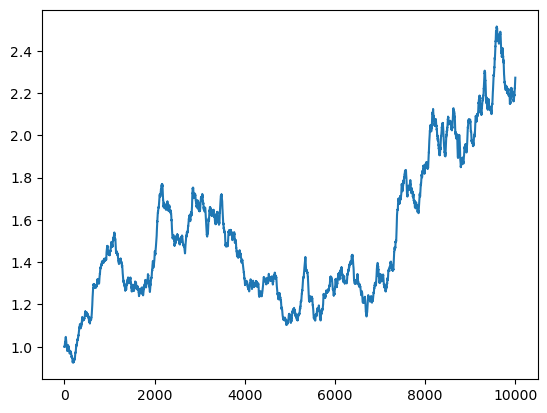

In [11]:
GSPC = yf.Ticker("^GSPC")
hist = GSPC.history(period="1y", interval="1d")
zt = hist["Close"].to_numpy()
# plt.plot(zt)

zt = gen_price_series()
plt.plot(zt)

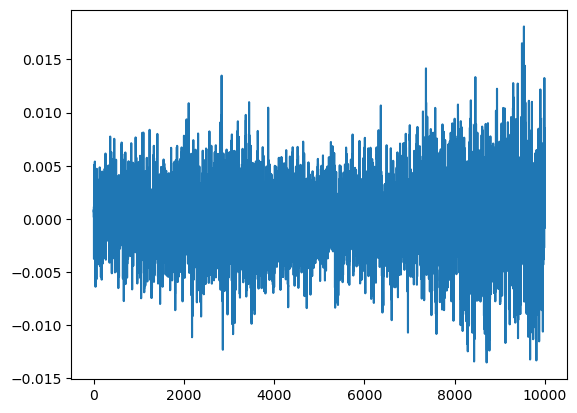

In [12]:
rt = np.ndarray((zt.shape[0],), dtype=float)
rt[0] = np.nan
rt[1:] = zt[1:] - zt[:-1]
plt.plot(rt)

c:\Users\jason\anaconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jason\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\jason\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jason\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\jason\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\jason\AppData\Local\Temp\ipykernel_14872\1097001797.py:41: RuntimeWarning: invalid value encount

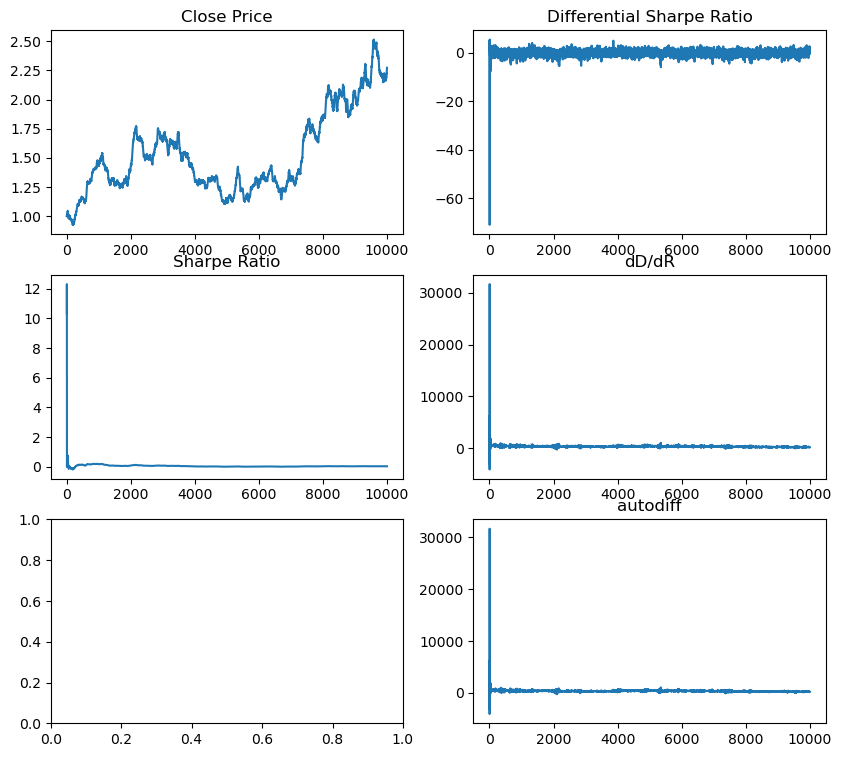

In [13]:
zt_trimmed = zt[:]


rt = np.ndarray((zt_trimmed.shape[0],), dtype=float)
rt[0] = np.nan
rt[1:] = zt_trimmed[1:] - zt_trimmed[:-1]
# plt.plot(rt)

# rt = np.zeros(zt.shape[0]) + 0.1

SERIES_LENGTH = rt.shape[0]

At = np.zeros((SERIES_LENGTH,))
Bt = np.zeros((SERIES_LENGTH,))

SR_series = np.zeros((SERIES_LENGTH,))
DSR_series = np.zeros((SERIES_LENGTH,))
dDT_series = np.zeros((SERIES_LENGTH,))
autodiff_series = np.zeros((SERIES_LENGTH,))

rt_tensor = tf.convert_to_tensor(rt, dtype=tf.float32)
DSR_tensor = tf.Variable(DSR_series, dtype=tf.float32)

N = 0.01
for i in range(1, SERIES_LENGTH):
    SR_series[i] = np.mean(rt[1:i]) / np.std(rt[1:i])
    
    t = i
    
    At[t] = At[t-1] + N * (rt[t] - At[t-1])
    Bt[t] = Bt[t-1] + N * (rt[t] ** 2 - Bt[t-1])

    with tf.GradientTape() as tape:
        rtVAR = tf.Variable(rt[t])
        dsrVAR = (Bt[t-1] * (rtVAR - At[t-1]) - (1/2) * (At[t-1] * (tf.math.square(rtVAR) - Bt[t-1]))) / ((Bt[t-1] - At[t-1] ** 2) ** 1.5)

    # print(rtVAR, dsrVAR)
    autodiff_series[t] = tape.gradient(dsrVAR, rtVAR)
    # print(autodiff_series[t])

    DSR_series[t] = (Bt[t-1] * (rt[t] - At[t-1]) - (1/2) * (At[t-1] * (rt[t] ** 2 - Bt[t-1]))) / (Bt[t-1] - At[t-1] ** 2) ** 1.5
    dDT_series[t] = (Bt[t-1] - At[t-1] * rt[t]) / ((Bt[t-1] - At[t-1] ** 2) ** 1.5)

figure, axis = plt.subplots(3, 2)
figure.set_size_inches(10, 9)

axis[0,0].plot(zt_trimmed)
axis[0,0].set_title("Close Price")

axis[1,0].plot(SR_series)
axis[1,0].set_title("Sharpe Ratio")

# print(At)
# print(Bt)
# print(DSR_series)
axis[0,1].plot(DSR_series)
axis[0,1].set_title("Differential Sharpe Ratio")


axis[1,1].plot(dDT_series)
axis[1,1].set_title("dD/dR")
axis[2,1].plot(autodiff_series)
axis[2,1].set_title("autodiff")

plt.show()

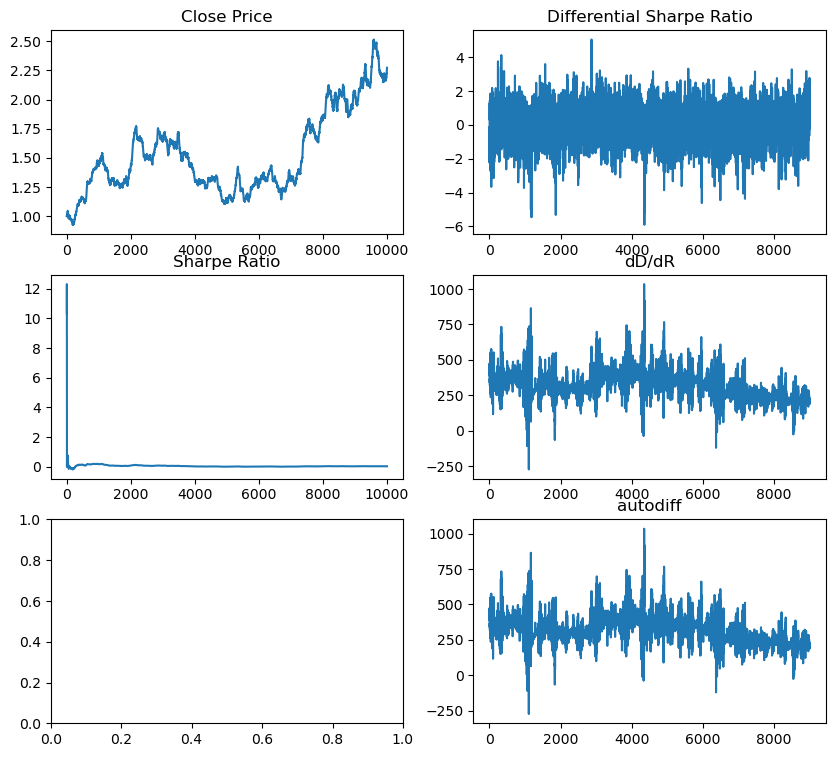

In [15]:

figure, axis = plt.subplots(3, 2)
figure.set_size_inches(10, 9)

axis[0,0].plot(zt_trimmed)
axis[0,0].set_title("Close Price")

axis[1,0].plot(SR_series)
axis[1,0].set_title("Sharpe Ratio")

# print(At)
# print(Bt)
# print(DSR_series)
axis[0,1].plot(DSR_series[1000:])
axis[0,1].set_title("Differential Sharpe Ratio")


axis[1,1].plot(dDT_series[1000:])
axis[1,1].set_title("dD/dR")
axis[2,1].plot(autodiff_series[1000:])
axis[2,1].set_title("autodiff")

plt.show()